<a href="https://colab.research.google.com/github/louis-sanna-eki/understand-llm/blob/master/Tokenizer_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Intro

In this notebook, we explore the compression ratios achieved by the [GPT tokenizer](https://github.com/openai/tiktoken) across the languages of the European Union. A higher ratio indicates better model performance.

Our analysis reveals a significant bias toward English, achieving a compression ratio of 4.99, compared to an average of 2.99 for other languages.

Generally, countries with larger populations and those using the same alphabet as English tend to have higher compression ratios. For example, Greek has a notably low ratio of 2.05.

We have utilized the translations of the [AI Act](https://artificialintelligenceact.eu/the-act/) as our dataset to compute these compression ratios.

This notebook was inspired by the insightful video from Andrej Karpathy, ["Let's Build the GPT Tokenizer"](https://www.youtube.com/watch?v=zduSFxRajkE&ab_channel=AndrejKarpathy).


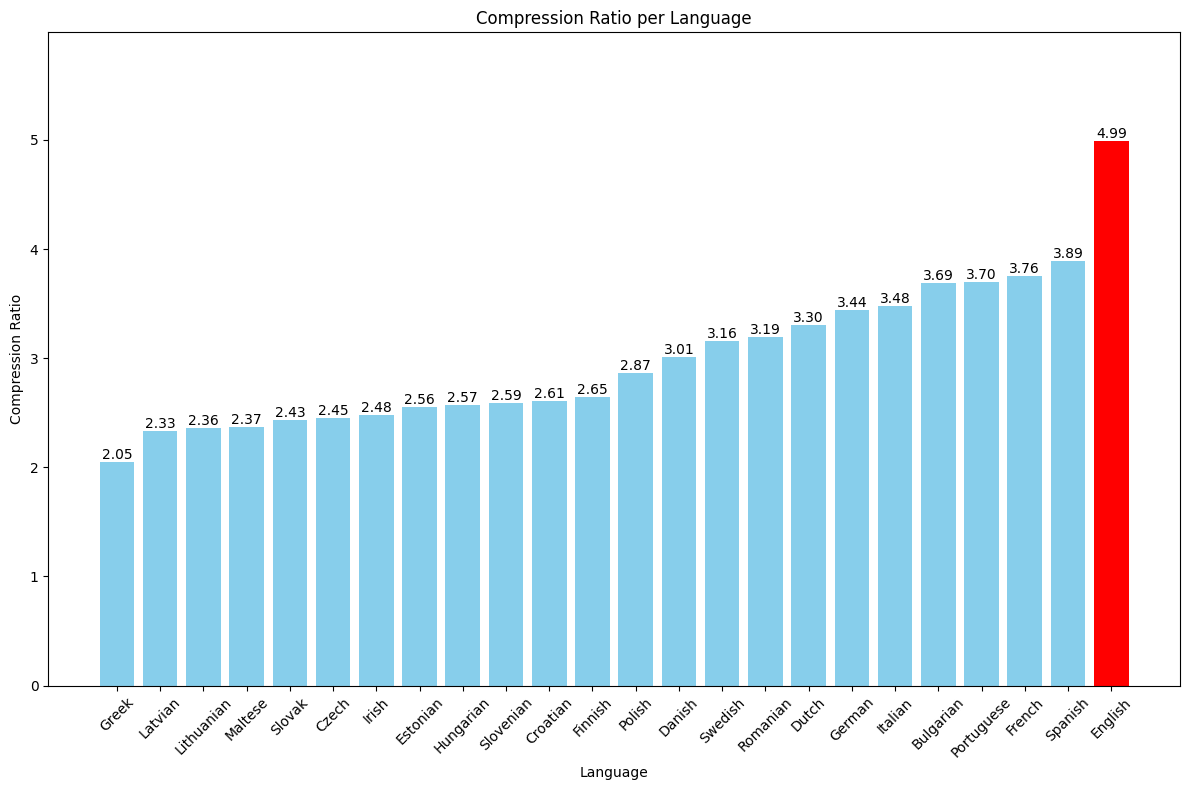

### Setup

In [26]:
!pip install tiktoken google-cloud-storage pymupdf matplotlib

### Compute compression

In [5]:
TEXT = "hello world!!!"

In [8]:
utf_tokens = TEXT.encode("utf-8") # raw bytes
utf_tokens = list(map(int, utf_tokens)) # convert to a list of integers in range 0..255 for convenience
print(utf_tokens)

[104, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100, 33, 33, 33]


In [12]:
import tiktoken

# GPT-4
enc = tiktoken.get_encoding("cl100k_base")
gpt_tokens = enc.encode(TEXT)
print(gpt_tokens)

[15339, 1917, 12340]


In [41]:
print(f"compression ratio: {len(utf_tokens) / len(gpt_tokens):.2f}")

compression ratio: 4.67


### Compute compression by language

From the website [Artificial Intelligence Act](https://artificialintelligenceact.eu/the-act/), we can access the AI Act in all the official languages of the European Union. The documents are available in a publicly accessible Google Cloud Storage bucket named 'ai-act-documents'.

In [23]:
BUCKET_NAME = "ai-act-documents"
CODE_TO_LANGUAGE = {
    "BG": "Bulgarian",
    "CS": "Czech",  # CS is an older code for Czech;
    "CZ": "Czech",
    "DA": "Danish",
    "DE": "German",
    "EL": "Greek",  # EL refers to the Greek name 'Ellinika'
    "EN": "English",
    "ES": "Spanish",
    "ET": "Estonian",
    "FI": "Finnish",
    "FR": "French",
    "GA": "Irish",  # Gaelic
    "HR": "Croatian",
    "HU": "Hungarian",
    "IT": "Italian",
    "LT": "Lithuanian",
    "LV": "Latvian",
    "MT": "Maltese",
    "NL": "Dutch",
    "PL": "Polish",
    "PT": "Portuguese",
    "RO": "Romanian",
    "SK": "Slovak",
    "SL": "Slovenian",
    "SV": "Swedish"
}

In [19]:
import google

google.colab.auth.authenticate_user()

In [36]:
from google.cloud import storage
import fitz  # PyMuPDF
import tiktoken

# Initialize the GPT-4 encoder
enc = tiktoken.get_encoding("cl100k_base")

def fetch_text_from_pdf(pdf_blob):
    """Extracts text from a given PDF blob."""
    pdf_file_stream = pdf_blob.download_as_bytes()
    document = fitz.open(stream=pdf_file_stream, filetype="pdf")
    text = ""
    for page in document:
        text += page.get_text()
    return text

def compute_compression_ratio(text):
    """Compute the compression ratio for the given text."""
    gpt_tokens = enc.encode(text)
    utf_tokens = text.encode("utf-8")
    utf_tokens = list(map(int, utf_tokens))
    return len(utf_tokens) / len(gpt_tokens) if len(gpt_tokens) > 0 else float('inf')  # Prevent division by zero

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
blobs = bucket.list_blobs()

results = []

for blob in blobs:
    if blob.name.endswith(".pdf"):
        print(f"Processing: {blob.name}")
        text = fetch_text_from_pdf(blob)
        compression_ratio = compute_compression_ratio(text)
        language_code = blob.name[-6:-4]  # Extract language code from filename
        language = CODE_TO_LANGUAGE.get(language_code, "Unknown Language")  # Get language from map
        results.append({
            "file": blob.name,
            "ratio": compression_ratio,
            "language": language
        })
        print(f"Compression ratio for {language}: {compression_ratio:.2f}")

Processing: TA-9-2024-0138_BG.pdf
Compression ratio for Bulgarian: 3.69
Processing: TA-9-2024-0138_CS.pdf
Compression ratio for Czech: 2.45
Processing: TA-9-2024-0138_DA.pdf
Compression ratio for Danish: 3.01
Processing: TA-9-2024-0138_DE.pdf
Compression ratio for German: 3.44
Processing: TA-9-2024-0138_EL.pdf
Compression ratio for Greek: 2.05
Processing: TA-9-2024-0138_EN.pdf
Compression ratio for English: 4.99
Processing: TA-9-2024-0138_ES.pdf
Compression ratio for Spanish: 3.89
Processing: TA-9-2024-0138_ET.pdf
Compression ratio for Estonian: 2.56
Processing: TA-9-2024-0138_FI.pdf
Compression ratio for Finnish: 2.65
Processing: TA-9-2024-0138_FR.pdf
Compression ratio for French: 3.76
Processing: TA-9-2024-0138_GA.pdf
Compression ratio for Irish: 2.48
Processing: TA-9-2024-0138_HR.pdf
Compression ratio for Croatian: 2.61
Processing: TA-9-2024-0138_HU.pdf
Compression ratio for Hungarian: 2.57
Processing: TA-9-2024-0138_IT.pdf
Compression ratio for Italian: 3.48
Processing: TA-9-2024-0

In [46]:
ratios = [result['ratio'] for result in results]
sum(ratios) / len(ratios)

2.9969106458034696

### Vizualisation

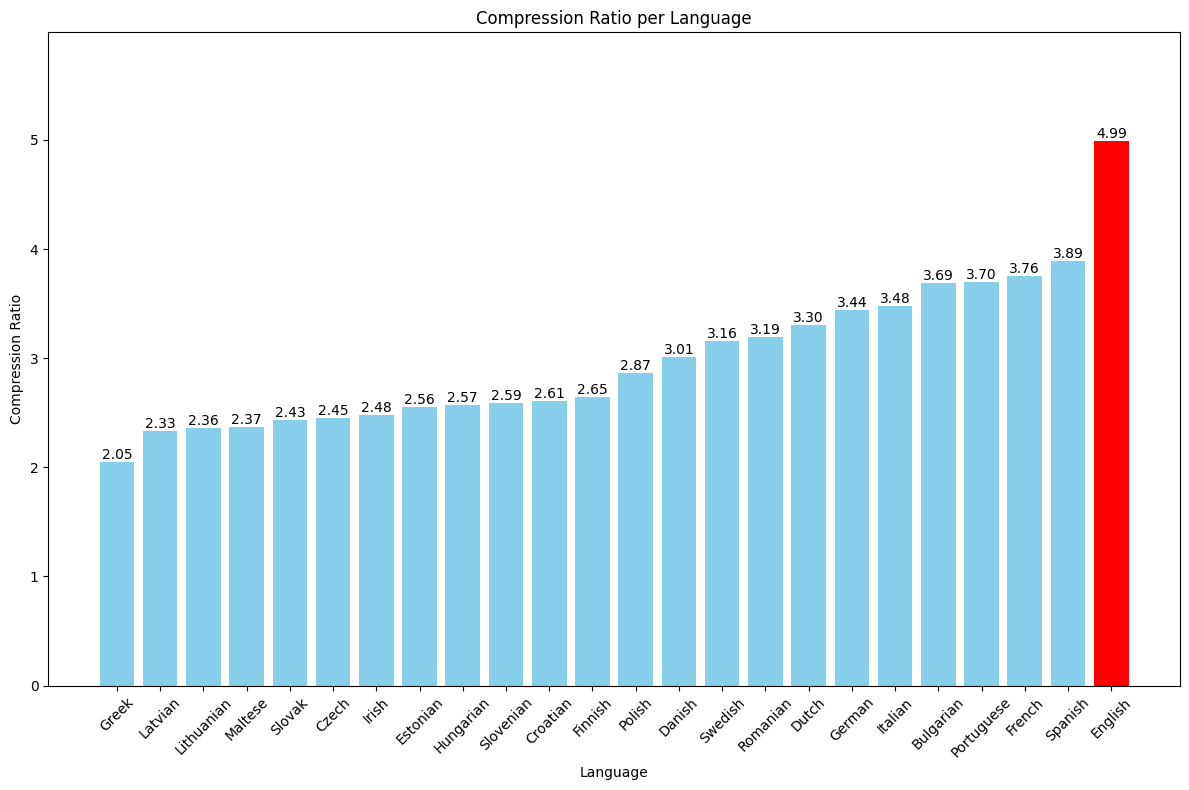

In [40]:
import matplotlib.pyplot as plt

sorted_results = sorted(results, key=lambda x: x['ratio'])

languages = [result['language'] for result in sorted_results]
ratios = [result['ratio'] for result in sorted_results]

# Plotting
plt.figure(figsize=(12, 8))
for i, (language, ratio) in enumerate(zip(languages, ratios)):
    color = 'red' if language == 'English' else 'skyblue'
    bar = plt.bar(language, ratio, color=color)
    plt.text(bar[0].get_x() + bar[0].get_width() / 2, ratio, f'{ratio:.2f}', ha='center', va='bottom')

plt.xlabel('Language')
plt.ylabel('Compression Ratio')
plt.title('Compression Ratio per Language')
plt.xticks(rotation=45)
plt.ylim(0, max(ratios) + 1)  # Set y-axis to start at 0 and adjust max to give some space above the highest bar
plt.tight_layout()
plt.show()